In [1]:
!nvidia-smi

Mon Apr  4 13:25:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:8B:00.0 Off |                  N/A |
| 40%   31C    P0    26W / 105W |      0MiB /  8117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Inštalácia knižníc

In [2]:
!pip install opencv-python
!pip install keras
!pip install scikit-plot

### Import knižníc

In [1]:
from sys import stdout
from tensorflow import keras
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from csv import DictWriter

import tensorflow as tf
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle as pkl

### Zadefinovanie funkcie

In [5]:
#vykreslenie procesu učenia
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Načítanie snímok

In [6]:
with open('train.pkl','rb') as f: X_train, train_df = pkl.load(f)
with open('test.pkl','rb') as f: X_test, test_df = pkl.load(f)
with open('valid.pkl','rb') as f: X_valid, valid_df = pkl.load(f)

y_train = train_df["category"]
y_test = test_df["category"]
y_valid = valid_df["category"]

In [7]:
print("TrainSetInto = {}".format(X_train.shape))
print("TestSetInto = {}".format(X_test.shape))
print("ValidSetInto = {}".format(X_valid.shape))

TrainSetInto = (4668, 299, 299, 1)
TestSetInto = (1191, 299, 299, 1)
ValidSetInto = (100, 299, 299, 1)


<AxesSubplot:>

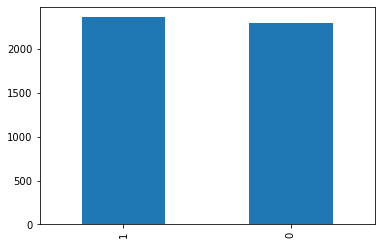

In [8]:
y_train.value_counts().plot.bar()

<AxesSubplot:>

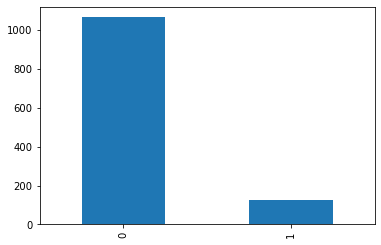

In [9]:
y_test.value_counts().plot.bar()

<AxesSubplot:>

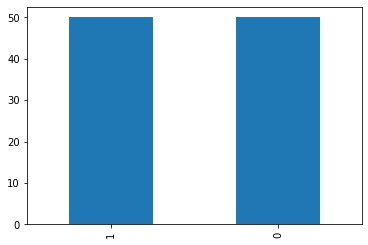

In [10]:
y_valid.value_counts().plot.bar()

### Architektúra siete

In [11]:
epochs = 40
batch_size = 32


model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=[299, 299,1], activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 295, 295, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 295, 295, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 147, 147, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 147, 147, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 145, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 143, 143, 32)      9

### Vytvorenie záchytných bodov

In [12]:
STEPS_PER_EPOCH = y_train.size / batch_size
SAVE_PERIOD = 2

filepath = "../FrantisekUrban/wandb_models_weights/decent-sweep-4-{epoch:02d}.h5"
checkpoint1 = ModelCheckpoint(filepath, verbose=1, save_best_only=False, save_weights_only=True, save_freq=int(SAVE_PERIOD * STEPS_PER_EPOCH))

### Augmentácia datasetu (trénovacia množina)

In [13]:
train_datagen = ImageDataGenerator(vertical_flip=True,horizontal_flip=True, brightness_range=[0.3,0.7])
train_img_gen = train_datagen.flow(X_train, y_train,
                                       batch_size=batch_size)

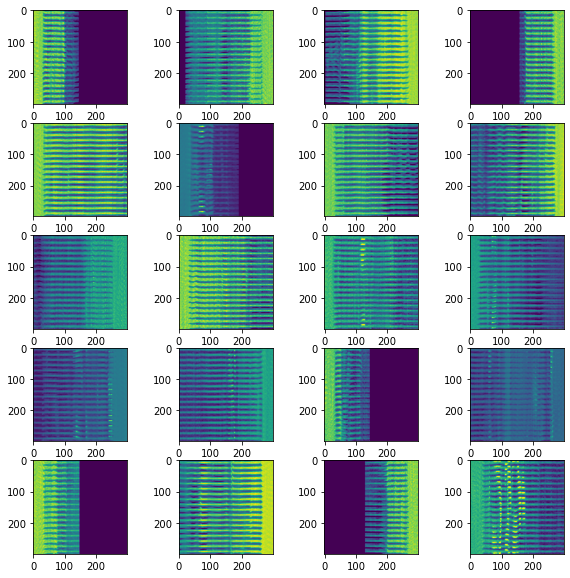

In [14]:
# vykreslenie výstupu augmentácie  
x_batch, y_batch = next(train_img_gen)
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
for i in range (1, columns*rows +1):
    image = x_batch[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

### Trénovanie modelu

In [18]:
# konfigurácia procesu trénovania
history = model.fit(train_img_gen,
                    validation_data = (X_valid, y_valid),
                    callbacks = [checkpoint1],
                    epochs=epochs)

Epoch 1/40
146/146 [==============================] - 21s 147ms/step - loss: 3.9545 - accuracy: 0.6581 - val_loss: 1.9270 - val_accuracy: 0.6800
Epoch 2/40
144/146 [============================>.] - ETA: 0s - loss: 0.7047 - accuracy: 0.7309
Epoch 00002: saving model to ../FrantisekUrban/wandb_models_weights/decent-sweep-4-02.h5
146/146 [==============================] - 21s 146ms/step - loss: 0.7005 - accuracy: 0.7322 - val_loss: 1.4339 - val_accuracy: 0.4900
Epoch 3/40
146/146 [==============================] - 20s 139ms/step - loss: 0.4632 - accuracy: 0.7778 - val_loss: 0.7633 - val_accuracy: 0.6300
Epoch 4/40
143/146 [============================>.] - ETA: 0s - loss: 0.4495 - accuracy: 0.7878
Epoch 00004: saving model to ../FrantisekUrban/wandb_models_weights/decent-sweep-4-04.h5
146/146 [==============================] - 21s 147ms/step - loss: 0.4483 - accuracy: 0.7890 - val_loss: 0.7162 - val_accuracy: 0.6700
Epoch 5/40
146/146 [==============================] - 20s 140ms/step - l

### Vyhodnotenie výsledkov procesu trénovania

In [8]:
# zadefinovanie architektúry modelu
def create_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), input_shape=[299, 299,1], activation='relu'))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [9]:
#načítanie výtvorených váh
weights = glob.glob("../FrantisekUrban/wandb_models_weights/" + "*.h5")
weights[80:100]

['../FrantisekUrban/wandb_models_weights/decent-sweep-4-02.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-04.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-06.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-08.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-10.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-12.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-14.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-16.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-18.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-20.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-22.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-24.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-26.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-28.h5',
 '../FrantisekUrban/wandb_models_weights/decent-sweep-4-30.h5',
 '../FrantisekUrban/wandb_models_weights

In [14]:
# vytvorenie dataframu pre uloženie výsledkov
header = ["Model", "Accuracy", "Loss", "AUC"]
dataframe = pd.DataFrame(columns = header)  
dataframe

,Model,Accuracy,Loss,AUC


In [15]:
# vyhodnotenie modelov
for weight in weights[80:100]:
    new_model = create_model()
    new_model.load_weights(weight)
    print(weight.split("/")[3])
    score = new_model.evaluate(X_test, y_test)
    
    y_pred = new_model.predict(X_test)
    y_int = np.zeros_like(y_pred)
    y_int[y_pred > 0.50] = 1
    y_testt = y_test.astype('float32')
    print("DONE")
    
    cm = confusion_matrix(y_testt, y_int)
    print('Confusion_matrix')
    print(cm)
    print('-------------------Classification_report-------------------')
    target_names = ['Negative', 'Positive']
    print(classification_report(y_testt, y_int, target_names=target_names))
    
    rocauc = roc_auc_score(y_test, y_pred)
    print('AUC: {}'.format(rocauc))
    print(" ")
    
    row = {'Model': weight.split("/")[3],
           'Accuracy': round(score[1],4),
           'Loss': round(score[0],4),
           'AUC':round(rocauc,4) ,
          }
    dataframe = dataframe.append(row, ignore_index=True)

decent-sweep-4-02.h5
38/38 [==============================] - 2s 48ms/step - loss: 0.4940 - accuracy: 0.8388
DONE
Confusion_matrix
[[988  78]
 [114  11]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.90      0.93      0.91      1066
    Positive       0.12      0.09      0.10       125

    accuracy                           0.84      1191
   macro avg       0.51      0.51      0.51      1191
weighted avg       0.82      0.84      0.83      1191

AUC: 0.6316022514071294
 
decent-sweep-4-04.h5
38/38 [==============================] - 2s 43ms/step - loss: 0.8464 - accuracy: 0.5298
DONE
Confusion_matrix
[[513 553]
 [  7 118]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.99      0.48      0.65      1066
    Positive       0.18      0.94      0.30       125

    accuracy                           0.53      1191
 

In [16]:
#zobrazenie dosiahnutých výsledkov
dataframe

,Model,Accuracy,Loss,AUC
0,decent-sweep-4-02.h5,0.8388,0.4940,0.6316
1,decent-sweep-4-04.h5,0.5298,0.8464,0.8202
2,decent-sweep-4-06.h5,0.8850,0.3360,0.8158
3,decent-sweep-4-08.h5,0.8581,0.3156,0.8660
4,decent-sweep-4-10.h5,0.9211,0.2374,0.8648
5,decent-sweep-4-12.h5,0.5256,1.7189,0.7738
6,decent-sweep-4-14.h5,0.7985,0.3961,0.8998
7,decent-sweep-4-16.h5,0.8841,0.2867,0.9084
8,decent-sweep-4-18.h5,0.6524,1.1402,0.9036
9,decent-sweep-4-20.h5,0.8816,0.2646,0.8926


In [ ]:
#uloženie dataframu
dataframe.to_csv("../FrantisekUrban/wandb_models_weights/decent-sweep-4.csv", index=False)

In [10]:
weights[98]

'../FrantisekUrban/wandb_models_weights/decent-sweep-4-38.h5'

### Vyhodnotenie najlepšieho modelu

In [11]:
# vyhodnotenie na prahu = 0.5
new_model = create_model()
new_model.load_weights(weights[98])
print(weights[98].split("/")[3])
new_model.evaluate(X_test, y_test)

y_pred = new_model.predict(X_test)

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
y_testt = y_test.astype('float32')
print("DONE")

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))

rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(round(rocauc, 4)))

decent-sweep-4-38.h5
38/38 [==============================] - 2s 47ms/step - loss: 0.4162 - accuracy: 0.8950
DONE
Confusion_matrix
[[956 110]
 [ 15 110]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.98      0.90      0.94      1066
    Positive       0.50      0.88      0.64       125

    accuracy                           0.90      1191
   macro avg       0.74      0.89      0.79      1191
weighted avg       0.93      0.90      0.91      1191

AUC: 0.9573


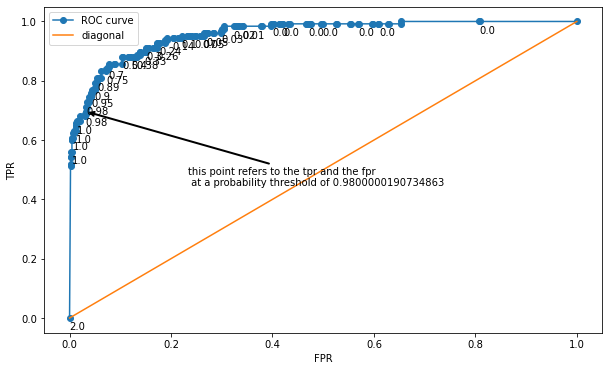

In [20]:
# vykreslenie ROC krivky s optimálnou hodnotou prahu
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 27
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("../FrantisekUrban/plots/decent-ROCcurve.png", bbox_inches='tight', dpi = 200)

In [13]:
# vyhodnotenie pri optimálnej hodnote prahu = 0.98
new_model = create_model()
new_model.load_weights(weights[98])
print(weights[98].split("/")[3])
new_model.evaluate(X_test, y_test)

y_pred = new_model.predict(X_test)

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.98] = 1
y_testt = y_test.astype('float32')
print("DONE")

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))

rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(round(rocauc, 4)))

decent-sweep-4-38.h5
38/38 [==============================] - 2s 42ms/step - loss: 0.4162 - accuracy: 0.8950
DONE
Confusion_matrix
[[1031   35]
 [  37   88]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97      1066
    Positive       0.72      0.70      0.71       125

    accuracy                           0.94      1191
   macro avg       0.84      0.84      0.84      1191
weighted avg       0.94      0.94      0.94      1191

AUC: 0.9573


In [2]:
#načítanie uloženého dataframu vysledkov
dataframe = pd.read_csv('../FrantisekUrban/wandb_models_weights/decent-sweep-4.csv')
dataframe

,Model,Accuracy,Loss,AUC
0,decent-sweep-4-02.h5,0.8388,0.4940,0.6316
1,decent-sweep-4-04.h5,0.5298,0.8464,0.8202
2,decent-sweep-4-06.h5,0.8850,0.3360,0.8158
3,decent-sweep-4-08.h5,0.8581,0.3156,0.8660
4,decent-sweep-4-10.h5,0.9211,0.2374,0.8648
5,decent-sweep-4-12.h5,0.5256,1.7189,0.7738
6,decent-sweep-4-14.h5,0.7985,0.3961,0.8998
7,decent-sweep-4-16.h5,0.8841,0.2867,0.9084
8,decent-sweep-4-18.h5,0.6524,1.1402,0.9036
9,decent-sweep-4-20.h5,0.8816,0.2646,0.8926


### Grafická reprezentácia výsledkov

In [3]:
# načítanie AUC a Úspešnosti
acc = dataframe["Accuracy"]
auc = dataframe["AUC"]

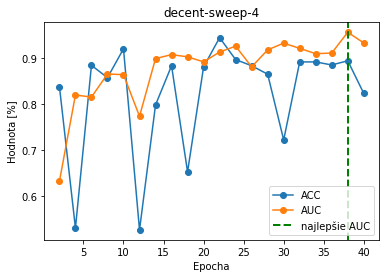

In [4]:
# vykreslenie grafu
epochs = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]

plt.plot(epochs, acc, label = 'ACC', linestyle='-', marker='o')
plt.plot(epochs, auc, label = 'AUC', linestyle='-', marker='o')

plt.axvline(x = 38, ls='--', lw=2, c='green', label='najlepšie AUC')
# naming the x axis
plt.xlabel('Epocha')
# naming the y axis
plt.ylabel('Hodnota [%]')
plt.title('decent-sweep-4')
plt.legend(loc ="lower right")
plt.savefig("../FrantisekUrban/plots/decentplot-vysledok-epoch.png", bbox_inches='tight', dpi = 200)
plt.show()